In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=2273c38259ba9cb1e73b47c9e47dad611080d57b48bfe452328d435a4d9aad91
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [3]:
LABELS = ['indoor', 'outdoor', 'transportation']

time: 1.19 ms


In [4]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'

time: 1.06 ms


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



In [5]:
def clear_csv(FILEPATH):
    if os.path.exists(FILEPATH):
        # clear the file
        f = open(FILEPATH, "w")
        f.truncate()
        f.close()

time: 2.26 ms


# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [300]:
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'
df = pd.DataFrame()
for i in range(1,17):
    filepath = BASE_PATH + 'FEATSALVARO/output-nomfcc' + str(i) +'.csv'
    print(filepath)
    new = pd.read_csv(filepath)
    df = pd.concat([df,new])

/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc1.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc2.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc3.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc4.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc5.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc6.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc7.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATSALVARO/output-nomfcc8.csv
/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/FEATS

In [301]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2067.040860,314.869340,0.001209,0.000798,0.002049,0.000470,-596.583604,162.614480,-0.670808,21.993716,16.195587,11.842820,11.357465,9.448603,8.314201,6.413948,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
1,2395.956778,837.186014,0.002879,0.004073,0.002581,0.000732,-561.432028,164.141569,-10.586786,11.820866,18.119139,23.761645,22.446430,15.891833,7.592193,8.502080,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
2,2135.921705,951.448528,0.002354,0.006510,0.002719,0.000589,-562.937612,172.182573,-4.441985,12.757403,14.173953,15.298843,18.722191,10.421974,8.023156,6.573807,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
3,3453.224033,2039.474046,0.009713,0.018070,0.002108,0.000442,-550.226488,139.243877,0.369526,16.225726,10.133525,45.845596,31.659723,15.694685,12.090169,11.095157,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
4,2306.123043,400.195968,0.002110,0.001470,0.001713,0.000348,-591.877872,158.679170,-3.883430,22.450031,18.368381,26.561454,11.428342,10.014569,8.082940,7.796495,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor


time: 48.1 ms


Factorizar nomes das musicas

In [302]:
#df['16'], unique = pd.factorize(df['16'])
#df.head(), unique

time: 938 µs


Factor Labels

In [303]:
#df['17'], unique = pd.factorize(df['17'])
#unique

time: 890 µs


In [304]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2067.040860,314.869340,0.001209,0.000798,0.002049,0.000470,-596.583604,162.614480,-0.670808,21.993716,16.195587,11.842820,11.357465,9.448603,8.314201,6.413948,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
1,2395.956778,837.186014,0.002879,0.004073,0.002581,0.000732,-561.432028,164.141569,-10.586786,11.820866,18.119139,23.761645,22.446430,15.891833,7.592193,8.502080,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
2,2135.921705,951.448528,0.002354,0.006510,0.002719,0.000589,-562.937612,172.182573,-4.441985,12.757403,14.173953,15.298843,18.722191,10.421974,8.023156,6.573807,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
3,3453.224033,2039.474046,0.009713,0.018070,0.002108,0.000442,-550.226488,139.243877,0.369526,16.225726,10.133525,45.845596,31.659723,15.694685,12.090169,11.095157,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor
4,2306.123043,400.195968,0.002110,0.001470,0.001713,0.000348,-591.877872,158.679170,-3.883430,22.450031,18.368381,26.561454,11.428342,10.014569,8.082940,7.796495,/content/drive/My Drive/tavares/soundfiles/TAU...,indoor


time: 41.6 ms


In [305]:
#df = df[df['17'] != 1]

time: 807 µs


In [306]:
#df[df['17'] != 0].shape, df[df['17'] != 2].shape

time: 856 µs


In [307]:
#df.sample(frac=0.1, random_state=1)

time: 791 µs


DF: Descrição

        features
*   0-9: MFCSS (media e std, respectivamente)
*   20: média centroide 
*   21: std centroide
*   22: media flatness
*   23: std flatness
*   24: rms

        outros
*   25: LABEL
*   26: Music_id






In [308]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns

time: 2.96 ms


Split no dataframe baseado em grupos do número da música

In [309]:
def split_by_music_id(df):
    coluna_ids_musica = len(df.columns) - 2
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, random_state = 42).split(df, groups=df.iloc[:,coluna_ids_musica].values))
    return [train_inds, test_inds]

time: 3.01 ms


Split no dataframe selecionado, em teste e treino

In [310]:
def split_train_test(df,train_inds, test_inds):
    X_train = (df.iloc[train_inds, 0:-2])
    X_test = (df.iloc[test_inds,0:-2])
    y_train = (df.iloc[train_inds,[-2,-1]]).values
    y_test = (df.iloc[test_inds,[-2,-1]]).values
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return [X_train, X_test, y_train, y_test]

time: 4.83 ms


In [311]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 3.06 ms


# Linear SVC Classifier

In [312]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

time: 3 ms


In [313]:
def get_model_linearSVC(X_train,y_train, y_test, X_test):
    C = [0.001, 0.01, 0.1, 1, 10, 100]
    for c in C:
        LSVC = LinearSVC(C = c, dual=False)
        LSVC.fit(X_train,y_train)
        y_pred = LSVC.predict(X_test)
        
        print("C: ", c)
        print("LSVC Accuracy :", accuracy_score(y_test, y_pred))
    filename = BASE_PATH + 'linearsvc_no_esp.pkl'
    joblib.dump(LSVC, filename,compress=0)
    return LSVC, y_pred

time: 7.97 ms


Contagem das predições para cada música

In [314]:
def plot_cf(y_pred, y_test):
    print(classification_report(y_test, y_pred))

time: 1.2 ms


In [315]:
def contagem_e_votacao(test_vs_pred):
    dic_names = dict()
    #print(len(test_vs_pred['16']))
    music_names_unique = np.unique(test_vs_pred['16'])
    for id in music_names_unique:
        dic_names[id] = []
    #print(len(dic_names))

    for name, label, pred in test_vs_pred.values:
        #print(name, label, pred)
        dic_names[name].append(pred)
    counter = [Counter(pred) for name,pred in dic_names.items()]
    #print(counter)
    
    #print(np.unique(y_test[1]))
    #print(counter, y_test)
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    #print(len(music_y_pred))
    music_y_test = (test_vs_pred[['16','17']].drop_duplicates())['17'].values
    #print((music_y_test))
    plot_cf(music_y_pred, music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 9.88 ms


In [316]:
def pca(X_test, y_test):
    pca = PCA(3)
    trans_pca = pca.fit_transform(X_test)
    trans_pca = pd.DataFrame(trans_pca)
    trans_pca['Labels'] = y_test
    trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
    print(pca.explained_variance_)
    trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

time: 5.41 ms


In [330]:
def get_split_alvaro(df):

    train_names = pd.read_pickle(BASE_PATH + 'FEATSALVARO/X_train.pickle')
    test_names = pd.read_pickle(BASE_PATH + 'FEATSALVARO/X_test.pickle')
    ytr = pd.read_pickle(BASE_PATH + 'FEATSALVARO/y_train.pickle')
    yts = pd.read_pickle(BASE_PATH + 'FEATSALVARO/y_test.pickle')
    X_train = df.loc[df['16'].isin(train_names)]
    X_test = df.loc[df['16'].isin(test_names)]
    y_train = X_train[['16', '17']]
    y_test = X_test[['16', '17']]
    X_train = X_train.drop(columns=['16','17'])
    X_test = X_test.drop(columns=['16','17'])
    #print(y_train, y_test,X_train, X_test)
    print(len(ytr), len(yts))
    print(len(y_train['17'].values), len(y_test['17'].values))
    print('---')
    print(len(train_names), len(test_names))
    print(len(X_train), len(X_test))
    return [X_train, X_test, y_train, y_test]


time: 15.5 ms


In [332]:
def classify(df):
    X_train, X_test, y_train, y_test = get_split_alvaro(df)
    X_train, X_test = standardize(X_train, X_test)
    model, y_pred = get_model_linearSVC(X_train, y_train['17'].values, y_test['17'].values, X_test)
    test_vs_pred = y_test
    test_vs_pred['pred'] = y_pred
    final_accuracy = contagem_e_votacao(test_vs_pred)
    pca(X_test, y_test['17'].values)
    return final_accuracy

time: 3.98 ms


1332 334
7470 1760
---
1332 334
7470 1760
1332
C:  0.001
LSVC Accuracy : 0.7926136363636364
C:  0.01
LSVC Accuracy : 0.8107954545454545
C:  0.1
LSVC Accuracy : 0.8164772727272728
C:  1
LSVC Accuracy : 0.8170454545454545
C:  10
LSVC Accuracy : 0.8176136363636364
C:  100
LSVC Accuracy : 0.8176136363636364
                precision    recall  f1-score   support

        indoor       0.75      0.82      0.78        61
       outdoor       0.97      0.91      0.94        35
transportation       0.87      0.82      0.85        80

      accuracy                           0.84       176
     macro avg       0.86      0.85      0.86       176
  weighted avg       0.85      0.84      0.84       176

[6.40809259 3.38248961 2.81853009]
0.8409090909090909


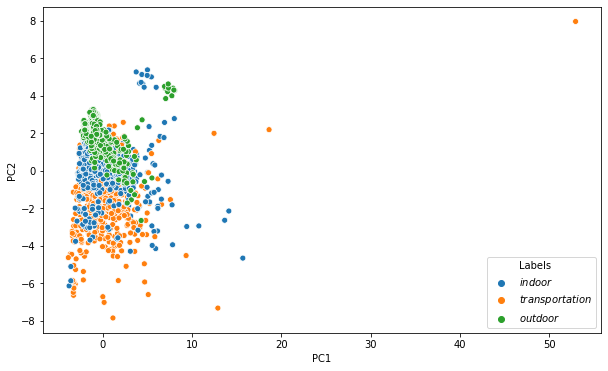

time: 851 ms


In [333]:
acc = classify(df)
print(acc)

Tamanho do modelo em KB

In [320]:
(os.path.getsize(BASE_PATH + 'linearsvc_no_esp.pkl')/1024)

1.2119140625

time: 3.51 ms
